# 性早熟预测模型

**基线数据 + 动态特征结合**

## 1. 导入必要的库

In [1]:
# 设置环境变量（必须在导入sklearn之前）
import os

os.environ["SCIPY_ARRAY_API"] = "1"

import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
)
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve
import xgboost as xgb
from tabpfn import TabPFNClassifier
import tabm
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import graphviz


plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

import re
import joblib

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

GPU: NVIDIA GeForce RTX 3080 Laptop GPU
显存: 16.0 GB


## 2. 设置路径和参数

In [2]:
os.makedirs("./output", exist_ok=True)
os.makedirs("./output/models", exist_ok=True)

RANDOM_SEED = 825
np.random.seed(RANDOM_SEED)
N_JOBS = -1

## 3. 读取数据

In [4]:
normal_data = pd.read_csv("./input/性早熟数据激发试验正常组_new.csv")
disease_data = pd.read_csv("./input/激发试验确诊性早熟组数据_new.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

print(f"正常组: {normal_data.shape[0]} 行, 早熟组: {disease_data.shape[0]} 行")

正常组: 8970 行, 早熟组: 10654 行


## 4. 数据类型处理和合并

In [5]:
data = pd.concat([normal_data, disease_data], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")
print(f"合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")

合并后数据: 19624 行 x 40 列


## 5. 查看数据基本信息

In [6]:
print("数据基本信息:")
print(f"数据维度: {data.shape}")
print(f"分组统计:")
print(data["group"].value_counts())
print(f"数据类型:")
print(data.dtypes.value_counts())
print(f"缺失值统计:")
missing_count = data.isnull().sum().sum()
print(f"总缺失值数量: {missing_count}")
if missing_count > 0:
    missing_by_col = data.isnull().sum()
    missing_by_col = missing_by_col[missing_by_col > 0].sort_values(ascending=False)
    print("各列缺失值:")
    print(missing_by_col.head(10))

数据基本信息:
数据维度: (19624, 40)
分组统计:
group
Y    10654
N     8970
Name: count, dtype: int64
数据类型:
float64     38
object       1
category     1
Name: count, dtype: int64
缺失值统计:
总缺失值数量: 321449
各列缺失值:
有无腋毛           17161
右乳腺体宽（cm）      14212
左乳腺体宽（cm）      14206
乳腺体宽平均值（cm）    14195
最大卵泡直径直径       14171
有无阴毛           13199
左乳腺体厚（cm）      13183
右乳腺体厚（cm）      13153
乳腺体厚平均值（cm）    13136
乳晕色素沉着         12758
dtype: int64


## 6. 划分训练集和验证集

In [7]:
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)

print(f"训练集: {train_data.shape[0]} 行, 验证集: {validation_data.shape[0]} 行")

训练集: 13736 行, 验证集: 5888 行


## 7. 特征工程

In [8]:
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()

y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

print(f"使用 {len(feature_cols)} 个特征")

使用 38 个特征


## 8. 特征概览和缺失值分析

In [9]:
print(f"特征列表 ({len(feature_cols)}个特征):")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

print(f"训练集形状: {X_train.shape}")
print(f"验证集形状: {X_validation.shape}")
print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

missing_train = X_train.isnull().sum()
missing_pct = (missing_train / len(X_train) * 100).round(2)
missing_info = (
    pd.DataFrame({"缺失数量": missing_train, "缺失率(%)": missing_pct})
    .query("缺失数量 > 0")
    .sort_values("缺失率(%)", ascending=False)
)

if not missing_info.empty:
    print(f"缺失值分析 (Top 10):")
    print(missing_info.head(10).to_string())
else:
    print("训练集无缺失值")

特征列表 (38个特征):
 1. 年龄
 2. 身高（cm）
 3. 体重（kg）
 4. BMI （体重Kg÷身高m）
 5. Tanner分期
 6. 乳晕色素沉着
 7. 乳核
 8. 有无阴毛
 9. 有无腋毛
10. 基础血清促黄体生成激素（LH）
11. 基础血清卵泡刺激素（FSH）
12. 子宫长（cm）
13. 子宫宽（cm）
14. 子宫厚（cm）
15. 子宫体积（长X宽X厚X0.5236）
16. 最大卵泡直径直径
17. 左卵巢长（cm）
18. 左卵巢宽（cm）
19. 左卵巢厚（cm）
20. 左卵巢体积（长X宽X厚X0.5233）
21. 右卵巢长（cm）
22. 右卵巢宽（cm）
23. 右卵巢厚（cm）
24. 右卵巢体积（长X宽X厚X0.5233）
25. 卵巢长平均值（cm）
26. 卵巢宽平均值（cm）
27. 卵巢厚平均值（cm）
28. 卵巢体积平均值
29. 左乳腺体宽（cm）
30. 左乳腺体厚（cm）
31. 右乳腺体宽（cm）
32. 右乳腺体厚（cm）
33. 乳腺体宽平均值（cm）
34. 乳腺体厚平均值（cm）
35. 骨龄(岁)
36. 骨龄与实际年龄比值
37. 生物年龄和骨龄之间的差异
38. 按CHN法测算，左手、腕骨发育成熟度评分
训练集形状: (13736, 38)
验证集形状: (5888, 38)
训练集正负样本: {1: 7457, 0: 6279}
验证集正负样本: {1: 3197, 0: 2691}
缺失值分析 (Top 10):
              缺失数量  缺失率(%)
有无腋毛         11974   87.17
最大卵泡直径直径      9936   72.34
右乳腺体宽（cm）     9919   72.21
左乳腺体宽（cm）     9915   72.18
乳腺体宽平均值（cm）   9907   72.12
左乳腺体厚（cm）     9216   67.09
有无阴毛          9216   67.09
右乳腺体厚（cm）     9203   67.00
乳腺体厚平均值（cm）   9190   66.90
乳晕色素沉着        8936   65.06


## 9. 数据类型转换

In [11]:
print("数据类型转换:")
print(f"转换前 - 训练集: {X_train.dtypes.value_counts().to_dict()}")

for col in feature_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors="coerce")
    X_validation[col] = pd.to_numeric(X_validation[col], errors="coerce")

print(f"转换后 - 训练集: {X_train.dtypes.value_counts().to_dict()}")

missing_after_convert = X_train.isnull().sum().sum()
if missing_after_convert > 0:
    print(f"数据类型转换后产生了 {missing_after_convert} 个新的缺失值")
    new_missing = X_train.isnull().sum()
    new_missing = new_missing[new_missing > 0].sort_values(ascending=False)
    print("新增缺失值的列:")
    print(new_missing.to_string())
else:
    print("数据类型转换完成，无新增缺失值")

print(
    f"数据准备完成: {len(feature_cols)}个特征, 训练样本{X_train.shape[0]}, 验证样本{X_validation.shape[0]}"
)

数据类型转换:
转换前 - 训练集: {dtype('float64'): 38}
转换后 - 训练集: {dtype('float64'): 38}
数据类型转换后产生了 224213 个新的缺失值
新增缺失值的列:
有无腋毛                    11974
最大卵泡直径直径                 9936
右乳腺体宽（cm）                9919
左乳腺体宽（cm）                9915
乳腺体宽平均值（cm）              9907
左乳腺体厚（cm）                9216
有无阴毛                     9216
右乳腺体厚（cm）                9203
乳腺体厚平均值（cm）              9190
乳晕色素沉着                   8936
乳核                       7394
子宫体积（长X宽X厚X0.5236）       7393
子宫宽（cm）                  7383
子宫厚（cm）                  7383
子宫长（cm）                  7374
左卵巢宽（cm）                 6723
左卵巢厚（cm）                 6721
左卵巢长（cm）                 6721
右卵巢厚（cm）                 6609
右卵巢宽（cm）                 6607
右卵巢长（cm）                 6606
卵巢宽平均值（cm）               6557
卵巢厚平均值（cm）               6556
卵巢长平均值（cm）               6555
骨龄与实际年龄比值                4150
生物年龄和骨龄之间的差异             4140
按CHN法测算，左手、腕骨发育成熟度评分     4139
骨龄(岁)                    4138
Tanner分期                 3633
BMI （体重Kg÷身高m）      

---
# 模型训练

## 10. 设置交叉验证策略

In [12]:
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_SEED)

print(f"验证策略: 5折交叉验证 x 3次重复 = {cv_strategy.get_n_splits()}轮")
print(f"训练集: {len(X_train)}样本, 正负比={y_train_binary.value_counts().to_dict()}")
print(
    f"验证集: {len(X_validation)}样本, 正负比={y_validation_binary.value_counts().to_dict()}"
)

验证策略: 5折交叉验证 x 3次重复 = 15轮
训练集: 13736样本, 正负比={1: 7457, 0: 6279}
验证集: 5888样本, 正负比={1: 3197, 0: 2691}


## 11. 训练模型1: GBM (梯度提升机)

In [13]:
gbm_model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=3,
    learning_rate=0.01,
    l2_regularization=0.1,
    min_samples_leaf=10,
    random_state=RANDOM_SEED,
)
gbm_model.fit(X_train, y_train_binary)

y_pred_gbm = gbm_model.predict(X_validation)
y_pred_proba_gbm = gbm_model.predict_proba(X_validation)[:, 1]
auc_gbm = roc_auc_score(y_validation_binary, y_pred_proba_gbm)
f1_gbm = f1_score(y_validation_binary, y_pred_gbm)

joblib.dump(gbm_model, "./output/models/gbm_model.pkl")
print(f"GBM AUC: {auc_gbm:.4f}, F1: {f1_gbm:.4f}")

GBM AUC: 0.8299, F1: 0.7978


## 12. 训练模型2: KNN (K近邻)

In [14]:
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_knn = scaler.fit_transform(imputer.fit_transform(X_train))
X_validation_knn = scaler.transform(imputer.transform(X_validation))

knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=N_JOBS)
knn_model.fit(X_train_knn, y_train_binary)

y_pred_knn = knn_model.predict(X_validation_knn)
y_pred_proba_knn = knn_model.predict_proba(X_validation_knn)[:, 1]
auc_knn = roc_auc_score(y_validation_binary, y_pred_proba_knn)
f1_knn = f1_score(y_validation_binary, y_pred_knn)

joblib.dump(
    {"model": knn_model, "imputer": imputer, "scaler": scaler},
    "./output/models/knn_model.pkl",
)
print(f"KNN AUC: {auc_knn:.4f}, F1: {f1_knn:.4f}")

KNN AUC: 0.7711, F1: 0.7499


## 13. 训练模型3: Naive Bayes (朴素贝叶斯)

In [15]:
X_train_nb = imputer.fit_transform(X_train)
X_validation_nb = imputer.transform(X_validation)

nb_model = GaussianNB()
nb_model.fit(X_train_nb, y_train_binary)

y_pred_nb = nb_model.predict(X_validation_nb)
y_pred_proba_nb = nb_model.predict_proba(X_validation_nb)[:, 1]
auc_nb = roc_auc_score(y_validation_binary, y_pred_proba_nb)
f1_nb = f1_score(y_validation_binary, y_pred_nb)

joblib.dump({"model": nb_model, "imputer": imputer}, "./output/models/nb_model.pkl")
print(f"NB AUC: {auc_nb:.4f}, F1: {f1_nb:.4f}")

NB AUC: 0.7268, F1: 0.5775


## 14. 训练模型4: XGBoost (极限梯度提升)

In [16]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.013,
    random_state=RANDOM_SEED,
    tree_method="hist",
    n_jobs=N_JOBS,
)
xgb_model.fit(X_train, y_train_binary)

y_pred_xgb = xgb_model.predict(X_validation)
y_pred_proba_xgb = xgb_model.predict_proba(X_validation)[:, 1]
auc_xgb = roc_auc_score(y_validation_binary, y_pred_proba_xgb)
f1_xgb = f1_score(y_validation_binary, y_pred_xgb)

joblib.dump(xgb_model, "./output/models/xgb_model.pkl")
print(f"XGB AUC: {auc_xgb:.4f}, F1: {f1_xgb:.4f}")

XGB AUC: 0.8823, F1: 0.8310


## 15. 训练模型5: Random Forest (随机森林)

In [17]:
rf_model = RandomForestClassifier(
    n_estimators=500, random_state=RANDOM_SEED, n_jobs=N_JOBS
)
rf_model.fit(X_train, y_train_binary)

y_pred_rf = rf_model.predict(X_validation)
y_pred_proba_rf = rf_model.predict_proba(X_validation)[:, 1]
auc_rf = roc_auc_score(y_validation_binary, y_pred_proba_rf)
f1_rf = f1_score(y_validation_binary, y_pred_rf)

joblib.dump(rf_model, "./output/models/rf_model.pkl")
print(f"RF AUC: {auc_rf:.4f}, F1: {f1_rf:.4f}")

RF AUC: 0.8529, F1: 0.8108


## 16. 训练模型6: RPART (决策树)

In [18]:
# 填充缺失值
imputer_rpart = SimpleImputer(strategy="median")
X_train_rpart = imputer_rpart.fit_transform(X_train)
X_validation_rpart = imputer_rpart.transform(X_validation)

# 训练RPART模型
rpart_model = DecisionTreeClassifier(
    max_depth=5, min_samples_split=50, min_samples_leaf=20, random_state=RANDOM_SEED
)
rpart_model.fit(X_train_rpart, y_train_binary)

y_pred_rpart = rpart_model.predict(X_validation_rpart)
y_pred_proba_rpart = rpart_model.predict_proba(X_validation_rpart)[:, 1]
auc_rpart = roc_auc_score(y_validation_binary, y_pred_proba_rpart)
f1_rpart = f1_score(y_validation_binary, y_pred_rpart)

joblib.dump(
    {"model": rpart_model, "imputer": imputer_rpart}, "./output/models/rpart_model.pkl"
)
print(f"RPART AUC: {auc_rpart:.4f}, F1: {f1_rpart:.4f}")

RPART AUC: 0.8014, F1: 0.7778


## 17. 训练模型7: GLM (逻辑回归)

In [19]:
# 训练GLM模型（逻辑回归）
X_train_glm = imputer.fit_transform(X_train)
X_validation_glm = imputer.transform(X_validation)

glm_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, n_jobs=N_JOBS)
glm_model.fit(X_train_glm, y_train_binary)

y_pred_glm = glm_model.predict(X_validation_glm)
y_pred_proba_glm = glm_model.predict_proba(X_validation_glm)[:, 1]
auc_glm = roc_auc_score(y_validation_binary, y_pred_proba_glm)
f1_glm = f1_score(y_validation_binary, y_pred_glm)

joblib.dump({"model": glm_model, "imputer": imputer}, "./output/models/glm_model.pkl")
print(f"GLM AUC: {auc_glm:.4f}, F1: {f1_glm:.4f}")

GLM AUC: 0.7644, F1: 0.7138


## 18. 训练模型8: SVM (支持向量机)

In [20]:
# 训练SVM模型（支持向量机）
X_train_svm = scaler.fit_transform(imputer.fit_transform(X_train))
X_validation_svm = scaler.transform(imputer.transform(X_validation))

svm_model = SVC(kernel="rbf", probability=True, random_state=RANDOM_SEED)
svm_model.fit(X_train_svm, y_train_binary)

y_pred_svm = svm_model.predict(X_validation_svm)
y_pred_proba_svm = svm_model.predict_proba(X_validation_svm)[:, 1]
auc_svm = roc_auc_score(y_validation_binary, y_pred_proba_svm)
f1_svm = f1_score(y_validation_binary, y_pred_svm)

joblib.dump(
    {"model": svm_model, "imputer": imputer, "scaler": scaler},
    "./output/models/svm_model.pkl",
)
print(f"SVM AUC: {auc_svm:.4f}, F1: {f1_svm:.4f}")

SVM AUC: 0.8323, F1: 0.7973


## 19. 训练模型9: NNET (神经网络)

In [21]:
# 训练NNET模型（神经网络）
X_train_nnet = scaler.fit_transform(imputer.fit_transform(X_train))
X_validation_nnet = scaler.transform(imputer.transform(X_validation))

nnet_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    random_state=RANDOM_SEED,
    early_stopping=True,
)
nnet_model.fit(X_train_nnet, y_train_binary)

y_pred_nnet = nnet_model.predict(X_validation_nnet)
y_pred_proba_nnet = nnet_model.predict_proba(X_validation_nnet)[:, 1]
auc_nnet = roc_auc_score(y_validation_binary, y_pred_proba_nnet)
f1_nnet = f1_score(y_validation_binary, y_pred_nnet)

joblib.dump(
    {"model": nnet_model, "imputer": imputer, "scaler": scaler},
    "./output/models/nnet_model.pkl",
)
print(f"NNET AUC: {auc_nnet:.4f}, F1: {f1_nnet:.4f}")

NNET AUC: 0.8470, F1: 0.8087


## 20. 加载模型10: TabPFN-HPO

In [20]:
# 加载HPO强化TabPFN模型（从TabPFN_Enhanced.ipynb训练的模型）

print("=" * 70)
print("加载HPO强化TabPFN模型")
print("=" * 70)

# 加载模型文件
hpo_model_path = "./output/enhanced/models/tabpfn_hpo.pkl"

# 加载模型和预处理器
hpo_data = joblib.load(hpo_model_path)
tabpfn_model = hpo_data["model"]
imputer_hpo = hpo_data["imputer"]

print(f"已加载HPO优化TabPFN模型")
print(f"模型路径: {hpo_model_path}")
print(f"模型类型: {type(tabpfn_model).__name__}")

# 数据预处理
X_train_tabpfn = imputer_hpo.transform(X_train)
X_validation_tabpfn = imputer_hpo.transform(X_validation)

# 验证集预测
print(f"\n在验证集上进行预测...")
y_pred_tabpfn = tabpfn_model.predict(X_validation_tabpfn)
y_pred_proba_tabpfn = tabpfn_model.predict_proba(X_validation_tabpfn)[:, 1]

# 计算性能指标
auc_tabpfn = roc_auc_score(y_validation_binary, y_pred_proba_tabpfn)
f1_tabpfn = f1_score(y_validation_binary, y_pred_tabpfn)

print(f"\nHPO强化TabPFN性能指标:")
print(f"  AUC: {auc_tabpfn:.4f}")
print(f"  F1:  {f1_tabpfn:.4f}")

# 保存到与其他模型一致的位置
joblib.dump(
    {"model": tabpfn_model, "imputer": imputer_hpo},
    "./output/models/tabpfn_model.pkl",
)
print(f"\n模型已复制到: ./output/models/tabpfn_model.pkl")
print("=" * 70)

加载HPO强化TabPFN模型
已加载HPO优化TabPFN模型
模型路径: ./output/enhanced/models/tabpfn_hpo.pkl
模型类型: TunedTabPFNClassifier

在验证集上进行预测...

HPO强化TabPFN性能指标:
  AUC: 0.9544
  F1:  0.8961

模型已复制到: ./output/models/tabpfn_model.pkl


## 21. 训练模型11: TabM

In [28]:
# 训练TabM模型
print("=" * 70)
print("训练TabM模型")
print("=" * 70)

import rtdl_num_embeddings
from sklearn.preprocessing import QuantileTransformer
import joblib

# QuantileTransformer预处理
X_train_processed = imputer.fit_transform(X_train)
noise = (
    np.random.default_rng(0)
    .normal(0.0, 1e-5, X_train_processed.shape)
    .astype(X_train_processed.dtype)
)
quantile_transformer = QuantileTransformer(
    n_quantiles=max(min(len(X_train_processed) // 30, 1000), 10),
    output_distribution="normal",
    subsample=10**9,
).fit(X_train_processed + noise)

X_train_transformed = quantile_transformer.transform(X_train_processed)
X_val_transformed = quantile_transformer.transform(imputer.transform(X_validation))

X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32).cuda()
y_train_tensor = torch.tensor(y_train_binary.values, dtype=torch.long).cuda()
X_val_tensor = torch.tensor(X_val_transformed, dtype=torch.float32).cuda()

print(f"训练集: {X_train_tensor.shape}, 验证集: {X_val_tensor.shape}")

# PiecewiseLinear嵌入
num_embeddings = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)

# 创建TabM模型
tabm_model = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings,
).cuda()

print(f"模型参数量: {sum(p.numel() for p in tabm_model.parameters()):,}")

# AdamW优化器配置
optimizer = torch.optim.AdamW(tabm_model.parameters(), lr=2e-3, weight_decay=3e-4)

gradient_clipping_norm = 1.0

amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
amp_enabled = True
print(f"AMP: {amp_dtype}\n")

# 训练配置
batch_size = 256
n_epochs = 500

# 训练循环
print("开始训练\n")
best_f1 = 0

for epoch in range(n_epochs):
    tabm_model.train()
    total_loss = 0

    batches = torch.randperm(len(X_train_tensor), device="cuda").split(batch_size)

    for batch_idx in batches:
        optimizer.zero_grad()

        with torch.autocast(device_type="cuda", enabled=amp_enabled, dtype=amp_dtype):
            logits = tabm_model(X_train_tensor[batch_idx], None)
            y_pred = logits.flatten(0, 1)
            y_true = y_train_tensor[batch_idx].repeat_interleave(tabm_model.backbone.k)
            loss = nn.functional.cross_entropy(y_pred, y_true)

        loss.backward()

        if gradient_clipping_norm is not None:
            torch.nn.utils.clip_grad_norm_(
                tabm_model.parameters(), gradient_clipping_norm
            )

        optimizer.step()
        total_loss += loss.item()

    # 验证
    tabm_model.eval()
    with torch.no_grad():
        val_logits = tabm_model(X_val_tensor, None)
        val_proba = torch.softmax(val_logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
        val_pred = (val_proba >= 0.5).astype(int)
        auc = roc_auc_score(y_validation_binary, val_proba)
        f1 = f1_score(y_validation_binary, val_pred)

    improved = f1 > best_f1
    print(
        f"Epoch {epoch:3d}: Loss={total_loss/len(batches):.4f}, F1={f1:.4f}, AUC={auc:.4f}{' *' if improved else ''}"
    )

    if improved:
        best_f1, best_auc, best_epoch = f1, auc, epoch
        torch.save(tabm_model.state_dict(), "./output/models/tabm_model.pt")
        joblib.dump(
            quantile_transformer, "./output/models/tabm_quantile_transformer.pkl"
        )

print(f"\n训练完成: 最佳F1={best_f1:.4f} (Epoch {best_epoch}), AUC={best_auc:.4f}")

# 最终预测
tabm_model.load_state_dict(
    torch.load("./output/models/tabm_model.pt", weights_only=True)
)
tabm_model.eval()

with torch.no_grad():
    y_pred_proba_tabm = (
        torch.softmax(tabm_model(X_val_tensor, None), dim=-1)
        .mean(dim=1)[:, 1]
        .cpu()
        .numpy()
    )
    y_pred_tabm = (y_pred_proba_tabm >= 0.5).astype(int)

auc_tabm = roc_auc_score(y_validation_binary, y_pred_proba_tabm)
f1_tabm = f1_score(y_validation_binary, y_pred_tabm)

print(f"显存峰值: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")
print(f"\nTabM最终性能: F1={f1_tabm:.4f}, AUC={auc_tabm:.4f}")
print(f"模型已保存: ./output/models/tabm_model.pt")
print("=" * 70)

训练TabM模型 - 官方推荐增强
训练集: torch.Size([13078, 34]), 验证集: torch.Size([5606, 34])
模型参数量: 700,032
AMP: torch.bfloat16

开始训练

Epoch   0: Loss=0.5680, F1=0.8070, AUC=0.8339 *
Epoch   1: Loss=0.4880, F1=0.8150, AUC=0.8546 *
Epoch   2: Loss=0.4569, F1=0.8223, AUC=0.8632 *
Epoch   3: Loss=0.4443, F1=0.8246, AUC=0.8708 *
Epoch   4: Loss=0.4320, F1=0.8228, AUC=0.8720
Epoch   5: Loss=0.4216, F1=0.8311, AUC=0.8784 *
Epoch   6: Loss=0.4148, F1=0.8176, AUC=0.8814
Epoch   7: Loss=0.4128, F1=0.8305, AUC=0.8805
Epoch   8: Loss=0.4023, F1=0.8322, AUC=0.8842 *
Epoch   9: Loss=0.4014, F1=0.8239, AUC=0.8855
Epoch  10: Loss=0.3953, F1=0.8373, AUC=0.8867 *
Epoch  11: Loss=0.3873, F1=0.8334, AUC=0.8855
Epoch  12: Loss=0.3851, F1=0.8246, AUC=0.8830
Epoch  13: Loss=0.3787, F1=0.8350, AUC=0.8862
Epoch  14: Loss=0.3810, F1=0.8261, AUC=0.8878
Epoch  15: Loss=0.3752, F1=0.8367, AUC=0.8858
Epoch  16: Loss=0.3711, F1=0.8357, AUC=0.8859
Epoch  17: Loss=0.3619, F1=0.8336, AUC=0.8876
Epoch  18: Loss=0.3634, F1=0.8189, AUC=0

In [32]:
# 模型性能汇总
models_summary = pd.DataFrame(
    {
        "模型": [
            "GBM",
            "KNN",
            "NB",
            "XGB",
            "RF",
            "RPART",
            "GLM",
            "SVM",
            "NNET",
            "TabPFN-HPO",
            "TabM",
        ],
        "AUC": [
            auc_gbm,
            auc_knn,
            auc_nb,
            auc_xgb,
            auc_rf,
            auc_rpart,
            auc_glm,
            auc_svm,
            auc_nnet,
            auc_tabpfn,
            auc_tabm,
        ],
        "F1": [
            f1_gbm,
            f1_knn,
            f1_nb,
            f1_xgb,
            f1_rf,
            f1_rpart,
            f1_glm,
            f1_svm,
            f1_nnet,
            f1_tabpfn,
            f1_tabm,
        ],
    }
).sort_values("AUC", ascending=False)

best_model_name = models_summary.iloc[0]["模型"]
best_model_auc = models_summary.iloc[0]["AUC"]
best_model_f1 = models_summary.iloc[0]["F1"]

print(f"模型性能 ({len(models_summary)}个模型):")
print(models_summary.to_string(index=False))
print(
    f"\n最佳模型: {best_model_name} (AUC = {best_model_auc:.4f}, F1 = {best_model_f1:.4f})"
)

模型性能 (11个模型):
        模型      AUC       F1
TabPFN-HPO 0.954416 0.896100
      TabM 0.888701 0.840000
       XGB 0.879968 0.815413
      NNET 0.845002 0.806581
       GBM 0.837489 0.806758
        RF 0.836867 0.802043
       SVM 0.829104 0.802755
     RPART 0.789702 0.781477
       KNN 0.774338 0.756823
        NB 0.769646 0.530370
       GLM 0.743797 0.723213

最佳模型: TabPFN-HPO (AUC = 0.9544, F1 = 0.8961)


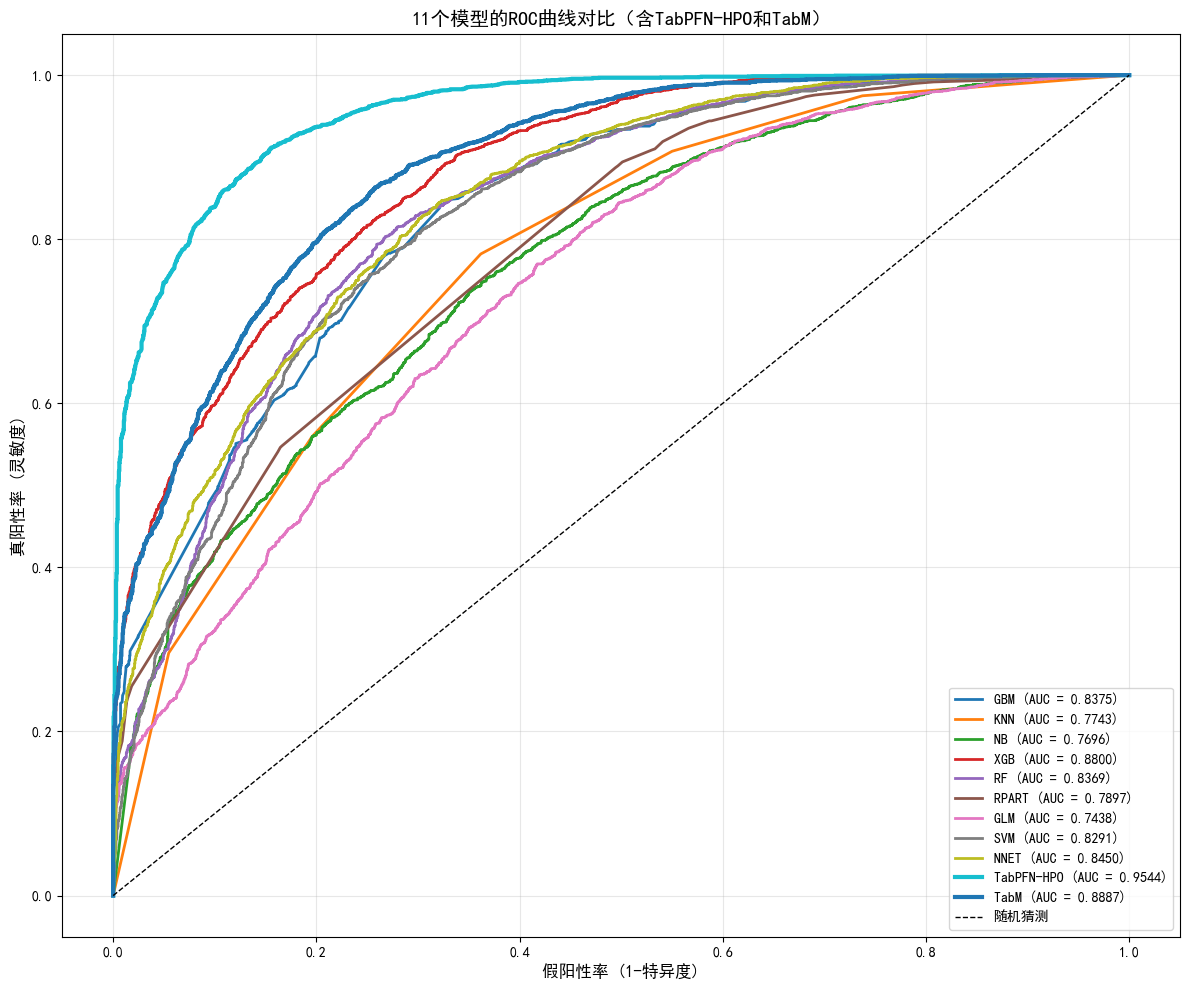

ROC曲线已保存


In [33]:
plt.figure(figsize=(12, 10))

# ROC曲线对比
models_info = [
    ("GBM", y_pred_proba_gbm, auc_gbm),
    ("KNN", y_pred_proba_knn, auc_knn),
    ("NB", y_pred_proba_nb, auc_nb),
    ("XGB", y_pred_proba_xgb, auc_xgb),
    ("RF", y_pred_proba_rf, auc_rf),
    ("RPART", y_pred_proba_rpart, auc_rpart),
    ("GLM", y_pred_proba_glm, auc_glm),
    ("SVM", y_pred_proba_svm, auc_svm),
    ("NNET", y_pred_proba_nnet, auc_nnet),
    ("TabPFN-HPO", y_pred_proba_tabpfn, auc_tabpfn),
    ("TabM", y_pred_proba_tabm, auc_tabm),
]

for model_name, y_proba, auc_score in models_info:
    fpr, tpr, _ = roc_curve(y_validation_binary, y_proba)
    linewidth = 3 if model_name in ["TabPFN-HPO", "TabM"] else 2
    plt.plot(
        fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})", linewidth=linewidth
    )

plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="随机猜测")
plt.xlabel("假阳性率 (1-特异度)", fontsize=12)
plt.ylabel("真阳性率 (灵敏度)", fontsize=12)
plt.title("11个模型的ROC曲线对比（含TabPFN-HPO和TabM）", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig("./output/ROC曲线对比_11模型.pdf", dpi=300, bbox_inches="tight")
plt.savefig("./output/ROC曲线对比_11模型.png", dpi=300, bbox_inches="tight")
plt.show()

print("ROC曲线已保存")

In [34]:
# 保存预测结果和性能指标
predictions_df = pd.DataFrame(
    {
        "真实标签": y_validation_binary,
        "GBM_预测": y_pred_gbm,
        "GBM_概率": y_pred_proba_gbm,
        "KNN_预测": y_pred_knn,
        "KNN_概率": y_pred_proba_knn,
        "NB_预测": y_pred_nb,
        "NB_概率": y_pred_proba_nb,
        "XGB_预测": y_pred_xgb,
        "XGB_概率": y_pred_proba_xgb,
        "RF_预测": y_pred_rf,
        "RF_概率": y_pred_proba_rf,
        "RPART_预测": y_pred_rpart,
        "RPART_概率": y_pred_proba_rpart,
        "GLM_预测": y_pred_glm,
        "GLM_概率": y_pred_proba_glm,
        "SVM_预测": y_pred_svm,
        "SVM_概率": y_pred_proba_svm,
        "NNET_预测": y_pred_nnet,
        "NNET_概率": y_pred_proba_nnet,
        "TabPFN-HPO_预测": y_pred_tabpfn,
        "TabPFN-HPO_概率": y_pred_proba_tabpfn,
        "TabM_预测": y_pred_tabm,
        "TabM_概率": y_pred_proba_tabm,
    }
)

predictions_df.to_csv(
    "./output/验证集预测结果_11模型.csv", index=False, encoding="utf-8-sig"
)
print(f"预测结果已保存，验证集共 {len(predictions_df)} 样本，包含11个模型的预测")

# 保存模型性能汇总
models_summary.to_csv(
    "./output/模型性能汇总_AUC_F1.csv", index=False, encoding="utf-8-sig"
)
print(f"模型性能汇总已保存 (包含AUC和F1指标)")

预测结果已保存，验证集共 5606 样本，包含11个模型的预测
模型性能汇总已保存 (包含AUC和F1指标)
